<a href="https://colab.research.google.com/github/prashanta4coursera/Pandas/blob/master/Insaid_cars_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSAID Project : Car_Sales Dataset
######  submitted by Prashanta Sinha
###### prashanta.sinha@gmail.com

### 1.0 Importing all the pyhton library for this project

In [0]:
# importing all library to be used in this project.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### 2.0 Downloading car_sales data from Project github
##### Step 1 : used " urllib.request " & " charder.detect " to know the encoding of the data
##### Step 2 : Downloaded the in the local directory, to do analhysis even w/o internet

In [0]:
#######################################################################################
# detect the dataset encoding ....

#import urllib.request
#rawdata = urllib.request.urlopen('https://raw.githubusercontent.com/insaid2018/Term-1/master/Data/Projects/car_sales.csv').read()
#import chardet
#chardet.detect(rawdata)
# Output : {'encoding': 'windows-1251', 'confidence': 0.99, 'language': 'Russian'}

#######################################################################################

cars = pd.read_csv('https://raw.githubusercontent.com/insaid2018/Term-1/master/Data/Projects/car_sales.csv', encoding = 'windows-1251',header = 0,parse_dates=['year'])


#######################################################################################

### 2.1 Read file

In [88]:
# Saved the file in local drive to use it even when I don't have internet connection.

cars.head(3)

,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.0,crossover,68,2.5,Gas,yes,2010-01-01,Kuga,full
1,Mercedes-Benz,20500.0,sedan,173,1.8,Gas,yes,2011-01-01,E-Class,rear
2,Mercedes-Benz,35000.0,other,135,5.5,Petrol,yes,2008-01-01,CL 550,rear


### 2.2 Change datatypes of the columns

In [89]:
# We will set price & engV as float, year as datetime
# & model as string to apply regEx to get rid of special character

cars['price'] = pd.to_numeric(cars['price'], errors = 'coerce')
cars['year'] = pd.to_datetime(cars['year'])
cars['engV'] = pd.to_numeric(cars['engV'], errors = 'coerce')
cars['model'] = cars['model'].astype(str)
cars['model'].str.replace('[^0-9A-Za-z_]+','')    #Thanks to acedmics team of Insaid.
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9576 entries, 0 to 9575
Data columns (total 10 columns):
car             9576 non-null object
price           9576 non-null float64
body            9576 non-null object
mileage         9576 non-null int64
engV            9142 non-null float64
engType         9576 non-null object
registration    9576 non-null object
year            9576 non-null datetime64[ns]
model           9576 non-null object
drive           9065 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 748.2+ KB


### 3.0 Pandas Profiling
##### Pre-Profiling to understand the data

In [0]:
#Pre-profiling activity
#import pandas_profiling
#pre_prof = cars.profile_report(title = 'Car Sales', style = {'full_width' : True})
#pre_prof.to_file(output_file = 'cars_prof.html')

### 4. Data Munging
#### 4.1 Sorting and removing duplicates

In [91]:
#Sorting the cars_df to visulize the misssing data

cars_sorted = cars.sort_values(by=['car','model','body','year'],ascending = True)

#I haven't removed duplicate rows as duplicate fields are allowed since same car with same feature could be sold

cars_sorted.reset_index(inplace = True)
cars_sorted = cars_sorted.drop(columns = 'index')
cars_sorted['sales'] = 1
cars_sorted.head(3)

,car,price,body,mileage,engV,engType,registration,year,model,drive,sales
0,Acura,11111.0,crossover,199,3.5,Petrol,yes,2005-01-01,MDX,full,1
1,Acura,15650.0,crossover,170,3.7,Petrol,yes,2008-01-01,MDX,full,1
2,Acura,17200.0,crossover,82,3.7,Petrol,yes,2008-01-01,MDX,full,1


### 4.2 Working with missing data

##### 4.2.1 Fixing missing values in "drive" column


In [92]:
# Looking at the data after sorting , looks like type of drive is fixed for model across car brands.

# 1. select model & drive column : 
a = cars_sorted[['model','drive']]

# 2. remove NaN rows : 
a.dropna(axis = 0, how = 'any', inplace = True)

# 3. Now remove duplicate rows :
b = a.drop_duplicates(keep = 'first')
b = b.rename(columns = {'drive' : 'New Drive'})
b = b.reset_index()
del b['index']

# 4. Now we have unique rows for model & drive columns
# Do vlookup in pandas with merge function :

result = cars_sorted.merge(b, on = 'model')
result['drive'] = np.where(result.drive.isnull(),result['New Drive'],result['drive'])
result['drive'].isnull().sum()

# got rid of missing values in drive column


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0

##### 4.2.2 Fixing missing values in "engV "column

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


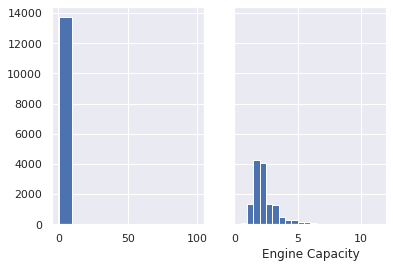

In [93]:
# Checking the frequency distribution of the engine types
fig, ax = plt.subplots(1,2,sharey = True)
ax[0].hist(result.engV)
plt.xlabel('Engine Capacity')
plt.xlim(0,100)

#Clearly, engV > 20 , 100 can't be possible from domain knowlege and are wrong entry in the system

#let's choose bin size of 0.5
bins = np.arange(0,12,0.5)
ax[1].hist(result.engV, bins = bins)
plt.xlabel('Engine Capacity')
plt.xlim(0,12)
plt.show()


In [94]:
# Let'make eng capacity > 30 to NaN
result1 = result.copy()
result1 = result1.drop('New Drive', axis = 1)
result1['engV'] = np.where(result.engV > 30,np.NaN,result1['engV'])

# Let's fill all NaN values with model median
engV_index = result1[result1['engV'].isna()]['model'].unique()
engV_index_series = pd.DataFrame(engV_index, columns = ['model'])
engV_index_series
model_median_list = list()
for x in engV_index : 
    model_median_list.append(result1[result1['model'] == x]['engV'].median())
df_engV_model = pd.DataFrame(model_median_list, columns = ['new engV'])
df_engV_model
result_engV = pd.concat([engV_index_series,df_engV_model], axis = 1, sort = False)
result_engV

result1_merged = result1.merge(result_engV, on ='model')
result1_merged['engV'] = np.where(result1_merged['engV'].isnull(),result1_merged['new engV'],result1_merged['engV'] )
result1_merged[result1_merged['engV'].isna()]

#Electric vehicles
#result1[result1['model'].str.contains('Electric' or 'model x')]

df_result = result1_merged.copy()
del_ind = df_result[df_result.engV.isna()].index.values


df_engV_null_del =df_result.drop(del_ind, axis = 0)
df_engV_null_del['engV'].isnull().sum()



0

In [0]:
# Checking for exceptional engines > 7

df_engV_exp_del = df_engV_null_del.copy()
df_engV_exp_del[df_engV_null_del['engV'] > 7]
#Looking at the table clearly engine capacity > 7 too can be replaced by the respective model median.

#['engV'] = np.where(df_engV_result['engV'] > 7, 'new engV', 'engV')
df_engV_null_del['engV'] = np.where(df_engV_null_del['engV'] > 7,df_engV_null_del['new engV'],df_engV_null_del['engV'])

#EngV data is clean now...

##### 3. Fixing mileage data in the dataset

In [96]:
mil_data = df_engV_null_del.copy()
mil_data.drop(columns = ['new engV'], axis = 1, inplace = True)
mil_data.describe()


,price,mileage,engV,sales
count,10033.000000,10033.000000,10033.000000,10033.0
mean,13652.228977,147.183793,2.098033,1.0
std,17127.651084,97.177002,0.789209,0.0
min,0.000000,0.000000,0.100000,1.0
25%,5000.000000,77.000000,1.600000,1.0
50%,9250.000000,138.000000,2.000000,1.0
75%,15300.000000,203.000000,2.500000,1.0
max,285000.000000,999.000000,7.000000,1.0


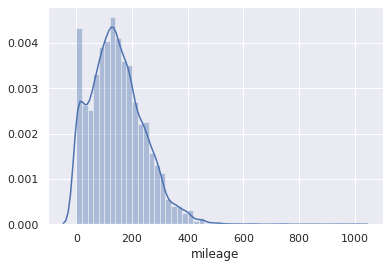

array([ 9,  1, 12, 18,  0, 11, 25,  4,  2, 27, 28, 10, 26, 17,  6,  5, 29,
       16,  8, 15, 23, 20, 19,  7, 14, 22, 24,  3, 21, 13])

In [97]:
sns.distplot(mil_data['mileage'])
plt.show()
mil_data[mil_data['mileage']<30]['mileage'].unique()

In [98]:
mil_data[mil_data['mileage'] >600]
# 999 mileage data is exception and needs to be updated

mil_data[mil_data['mileage']<30]
# clearly these are also exception.

mil_data['mileage'] = np.where(mil_data['mileage'] < 30,np.NaN,mil_data['mileage'])
mil_data['mileage'] = np.where(mil_data['mileage'] > 700,np.NaN,mil_data['mileage'])
mil_data.head(3)

,car,price,body,mileage,engV,engType,registration,year,model,drive,sales
0,Audi,7000.0,other,126.0,2.6,Petrol,yes,1998-01-01,80,front,1
1,Audi,7000.0,other,126.0,2.6,Petrol,yes,1998-01-01,80,front,1
2,Audi,600.0,sedan,112.0,1.6,Petrol,yes,1980-01-01,80,front,1


In [99]:
median_mil = mil_data.groupby(['model','engV'], as_index = False)['mileage'].median()
median_mil.rename(columns = {'mileage' : 'new_mileage'}, inplace = True)
median_mil
mil_data_merged = mil_data.merge(median_mil, on = ['model','engV'])
mil_data_merged['mileage'] = np.where(mil_data_merged['mileage'].isna(),mil_data_merged['new_mileage'],mil_data_merged['mileage'])
mil_data_merged['mileage'].isna().sum()

106

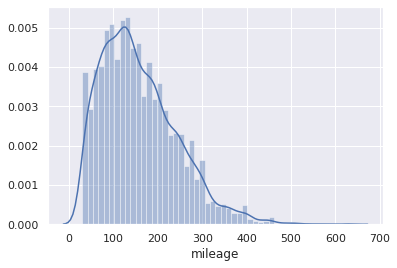

In [100]:
mil_data_merged[mil_data_merged['mileage'].isna()]
med_mil_car = mil_data_merged.groupby('car', as_index = False)['mileage'].median()
med_mil_car.columns = ['car','car_mileage']
med_mil_car
med_mil_car_merged = mil_data_merged.merge(med_mil_car, on = ['car'] )
med_mil_car_merged['mileage'] = np.where(med_mil_car_merged['mileage'].isna(),med_mil_car_merged['car_mileage'],med_mil_car_merged['mileage'])
med_mil_car_merged['mileage'].isna().sum()
sns.distplot(med_mil_car_merged['mileage'])
plt.show()
# Mileage data fixed!

Let's work on prices now !

In [101]:
med_mil_car_merged.describe()


,price,mileage,engV,sales,new_mileage,car_mileage
count,10033.000000,10033.000000,10033.000000,10033.0,9927.000000,10033.000000
mean,13652.228977,157.782667,2.098033,1.0,155.213307,152.464118
std,17127.651084,85.125656,0.789209,0.0,67.956862,47.605389
min,0.000000,30.000000,0.100000,1.0,30.000000,31.000000
25%,5000.000000,92.000000,1.600000,1.0,110.000000,117.500000
50%,9250.000000,142.000000,2.000000,1.0,140.000000,150.000000
75%,15300.000000,207.000000,2.500000,1.0,204.500000,206.000000
max,285000.000000,630.000000,7.000000,1.0,580.000000,220.000000


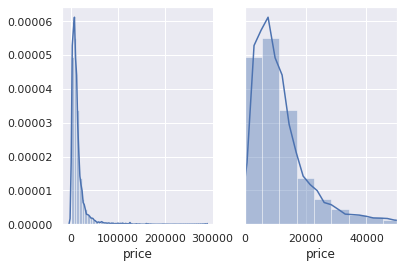

In [102]:
bins = np.arange(0,100000,5000)
fig, ax = plt.subplots(1,2, sharey = True)
sns.distplot(med_mil_car_merged['price'], ax = ax[0])

plt.xlim(0,50000)
sns.distplot(med_mil_car_merged['price'], ax = ax[1])
plt.show()

In [103]:
med_mil_car_merged[med_mil_car_merged['price'] > 200000]
# clearly price > 200000 aren't outliers as Land Rover could cost that much with a 5L engine.

a = med_mil_car_merged[med_mil_car_merged['price']<500]['price'].unique()
b = sorted(a)
# [0.0,
# 259.35,
# 280.0,
# 350.0,
# 370.5,
# 389.025,
# 400.0,
# 407.55,
# 460.0,
# 463.125,
# 499.0
# clearly only outlier is price of 0, rest all price are possible. 


######### Let's set price 0 as NaN ###########
price_df = med_mil_car_merged.copy()
price_df['price'] = np.where(price_df['price'] == 0, np.NaN, price_df['price'])
price_df[price_df['price'].isna()]
price_df.drop(columns = ['new_mileage','car_mileage'], axis = 1, inplace = True)
price_df.head(3)

,car,price,body,mileage,engV,engType,registration,year,model,drive,sales
0,Audi,7000.0,other,126.0,2.6,Petrol,yes,1998-01-01,80,front,1
1,Audi,7000.0,other,126.0,2.6,Petrol,yes,1998-01-01,80,front,1
2,Audi,600.0,sedan,112.0,1.6,Petrol,yes,1980-01-01,80,front,1


In [104]:
price_df_group = price_df.groupby(['car','model','engV'], as_index = False)['price'].mean()
price_df_group[price_df_group.price.isna()]
price_df_merged = price_df.merge(price_df_group, on = ['car','model','engV'])
price_df_merged.rename(columns = {'price_x': 'price', 'price_y' : 'mean_price'}, inplace = True)
price_df_merged['price'] = np.where(price_df_merged['price'].isna(),price_df_merged['mean_price'],price_df_merged['price'])
price_df_merged['price'].isna().sum() #7
#there are only 7 rows left which are NaN and thus can be dropped.

price_df_clean = price_df_merged.dropna(axis = 0, how = 'any')
price_df_clean.drop(columns = ['mean_price','sales'],axis = 1, inplace = True)
price_df_clean['price'].isna().sum()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0

In [0]:
## 5.0 Post Profiling

In [0]:
#Post-profiling activity
#import pandas_profiling
#post_prof = price_df_clean.profile_report(title = 'Car Sales', style = {'full_width' : True})
#post_prof.to_file(output_file = 'cars_post_prof.html')

## 6.0 EDA

### 1. Car sales over the year

In [107]:
cars_df = price_df_clean.copy()
cars_df['sales'] = 1
cars_df['int_year'] = cars_df['year'].dt.year.astype(str)
cars_df.head(3)

,car,price,body,mileage,engV,engType,registration,year,model,drive,sales,int_year
0,Audi,7000.0,other,126.0,2.6,Petrol,yes,1998-01-01,80,front,1,1998
1,Audi,7000.0,other,126.0,2.6,Petrol,yes,1998-01-01,80,front,1,1998
2,Audi,600.0,sedan,112.0,1.6,Petrol,yes,1980-01-01,80,front,1,1980


In [108]:
cars_df.describe()

,price,mileage,engV,sales
count,10026.000000,10026.000000,10026.000000,10026.0
mean,14614.693058,157.765959,2.097465,1.0
std,18313.686366,85.134486,0.787591,0.0
min,259.350000,30.000000,0.100000,1.0
25%,5500.000000,92.000000,1.600000,1.0
50%,9600.000000,142.000000,2.000000,1.0
75%,15900.000000,207.000000,2.500000,1.0
max,285000.000000,630.000000,6.300000,1.0


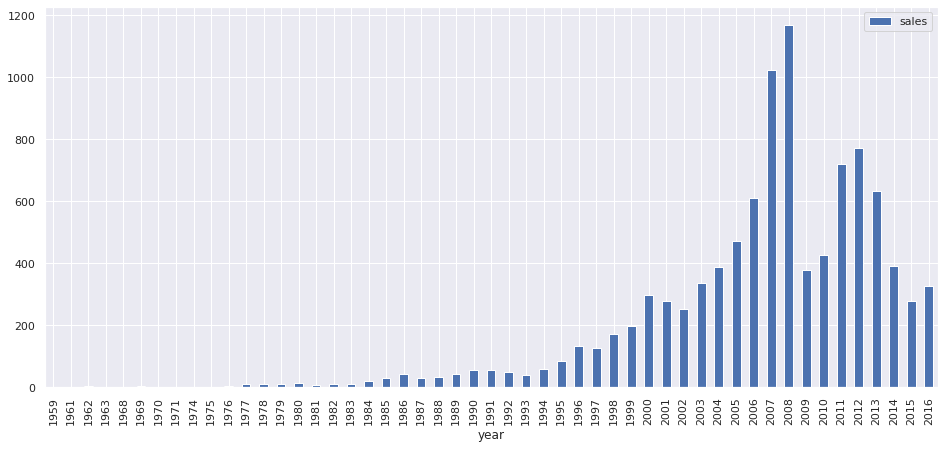

In [109]:
cars_df.groupby(cars_df['year'].dt.year)[['year','sales']].sum().plot(kind = 'bar', figsize =(16,7))
plt.show()

### Variation of Price (mean) , Mileage (mean), Engine capacity (median) & Sales (sum) over the years

In [110]:
data = cars_df[cars_df['year'].dt.year > 1995].groupby('int_year').agg({'price':'mean', 'mileage':'mean', 'engV':'median','sales':'sum' })
data.rename(index = {'int_year': 'year'},inplace = True)
data.head(3)

,price,mileage,engV,sales
int_year,,,,
1996,3780.655702,274.274436,1.9,133
1997,4758.173228,276.712598,2.5,127
1998,4744.909064,279.423977,2.0,171


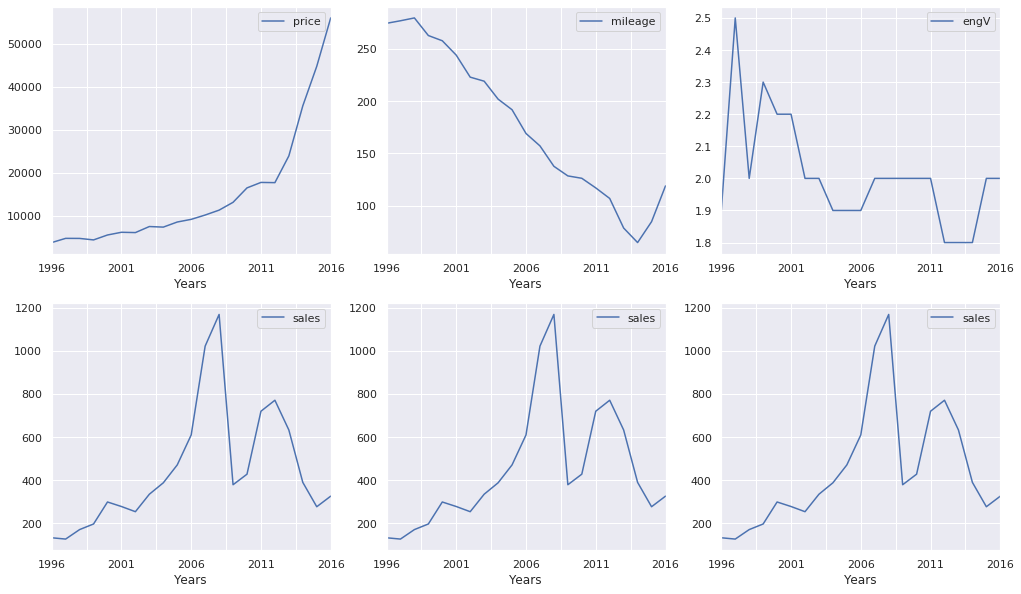

In [111]:
fig = plt.figure(figsize = (17,10))

ax1 = fig.add_subplot(2,3,1)
data[['price']].plot(ax = ax1)
plt.xlabel('Years', fontsize = 12)

ax2 = fig.add_subplot(2,3,2)
data[['mileage']].plot(ax = ax2)
plt.xlabel('Years', fontsize = 12)

ax3 = fig.add_subplot(2,3,3)
data[['engV']].plot(ax = ax3)
plt.xlabel('Years', fontsize = 12)

ax4 = fig.add_subplot(2,3,4)
data[['sales']].plot(ax = ax4)
plt.xlabel('Years', fontsize = 12)

ax5 = fig.add_subplot(2,3,5)
data[['sales']].plot(ax = ax5)
plt.xlabel('Years', fontsize = 12)

ax6 = fig.add_subplot(2,3,6)
data[['sales']].plot(ax = ax6)
plt.xlabel('Years', fontsize = 12)

plt.show()


### Mean : Price, Mileage, Engine Capacity; Sum (sales) over the years

In [112]:
bins = np.arange(0,7,0.5)
engV_df = cars_df.groupby(pd.cut(cars_df['engV'],bins = bins)).agg({'price': 'mean', 'mileage':'mean','engV':'mean','sales':'sum'})
engV_df

,price,mileage,engV,sales
engV,,,,
"(0.0, 0.5]",28650.000000,64.925000,0.110000,10
"(0.5, 1.0]",22297.017231,64.271795,0.703269,390
"(1.0, 1.5]",5931.296360,134.055040,1.414515,1885
"(1.5, 2.0]",11647.212554,153.938615,1.827746,3869
"(2.0, 2.5]",12527.806400,193.905711,2.360241,2031
"(2.5, 3.0]",29410.853540,183.865637,2.936517,1068
"(3.0, 3.5]",17005.162165,170.371233,3.400671,365
"(3.5, 4.0]",22804.021053,157.547368,3.803158,95
"(4.0, 4.5]",59138.921232,123.970930,4.365698,172


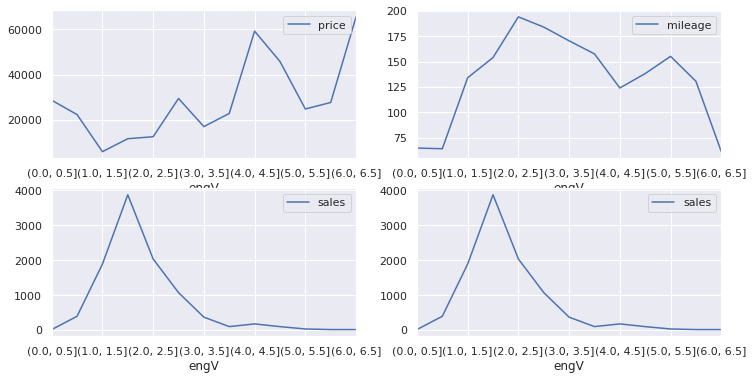

In [113]:
sns.set()
fig = plt.figure(figsize =(12,6))

ax1 = fig.add_subplot(2,2,1)
engV_df[['price']].plot(ax = ax1)
#plt.axvline(x = '(1.5, 2.0]', color = 'r')

ax2 = fig.add_subplot(2,2,2)
engV_df[['mileage']].plot(ax = ax2)

ax3 = fig.add_subplot(2,2,3)
engV_df[['sales']].plot(ax = ax3)

ax4 = fig.add_subplot(2,2,4)
engV_df[['sales']].plot(ax = ax4)
plt.show()

### Sales of car based on Fuel type

In [114]:
fuel_df = pd.DataFrame(cars_df[cars_df['year'].dt.year > 1995].groupby('year')['engType'].value_counts())
fuel_df.rename(columns = {'engType': 'engType_count'}, inplace = True)
fuel_df.head(5)

engType_count
year       engType               
1996-01-01 Petrol              51
           Diesel              45
           Gas                 24
           Other               13
1997-01-01 Petrol              47

In [115]:
fuel_df_pivot = fuel_df.reset_index().pivot('year','engType','engType_count').fillna(0)
fuel_df_pivot['Diesel%'] = np.round(fuel_df_pivot['Diesel'] / fuel_df_pivot.sum(axis = 1) * 100)
fuel_df_pivot['Petrol%'] = np.round(fuel_df_pivot['Petrol'] / fuel_df_pivot.sum(axis = 1) * 100)
fuel_df_pivot['Gas%'] = np.round(fuel_df_pivot['Gas'] / fuel_df_pivot.sum(axis = 1) * 100)
fuel_df_pivot['Other%'] = np.round(fuel_df_pivot['Other'] / fuel_df_pivot.sum(axis = 1) * 100)
fuel_df_pivot.head(3)

engType,Diesel,Gas,Other,Petrol,Diesel%,Petrol%,Gas%,Other%
year,,,,,,,,
1996-01-01,45.0,24.0,13.0,51.0,34.0,31.0,12.0,6.0
1997-01-01,44.0,34.0,2.0,47.0,35.0,29.0,18.0,1.0
1998-01-01,67.0,49.0,3.0,52.0,39.0,25.0,21.0,1.0


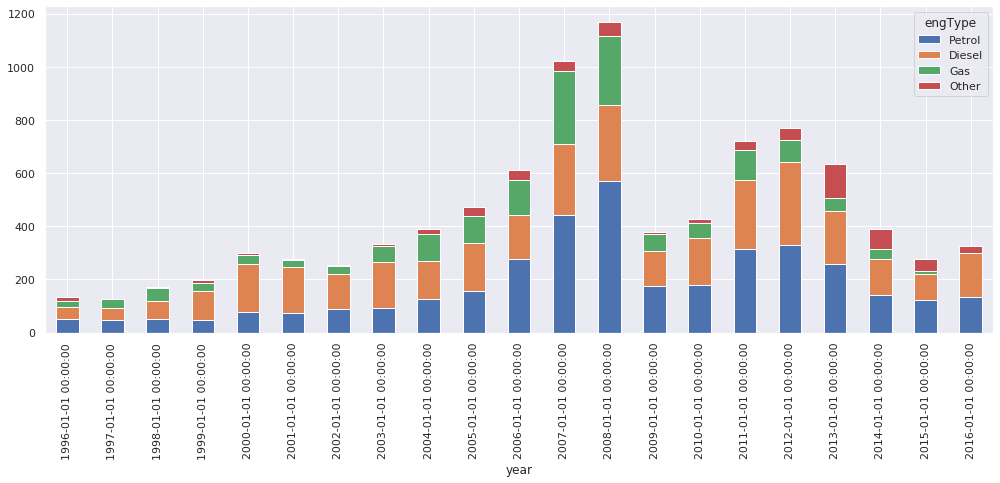

In [116]:
sns.set()
fuel_df_pivot.loc[:,['Petrol','Diesel','Gas','Other']].plot.bar(stacked = True, figsize = (17,6))
plt.show()

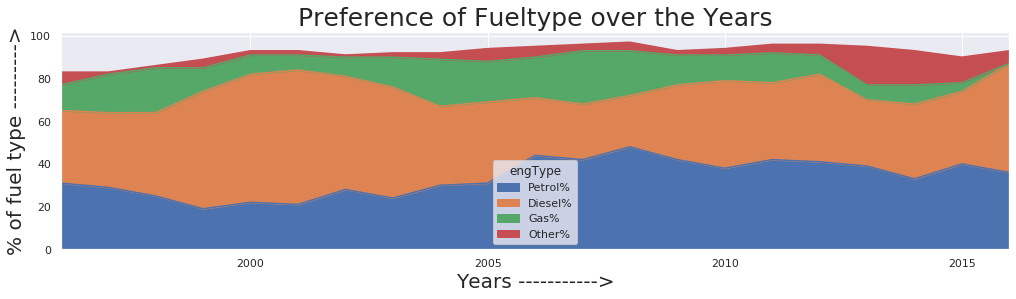

In [117]:
fig = plt.figure(figsize = (17,10))

ax1 = fig.add_subplot(1,1,1)
fuel_df_pivot.loc[:,['Petrol%','Diesel%','Gas%','Other%']].plot.area(figsize = (17,4), ax = ax1)

plt.title('Preference of Fueltype over the Years', fontsize = 25)
plt.xlabel('Years ----------->', fontsize = 20)
plt.ylabel('% of fuel type --------->', fontsize = 20)
plt.show()

### Price of car over the years (median)

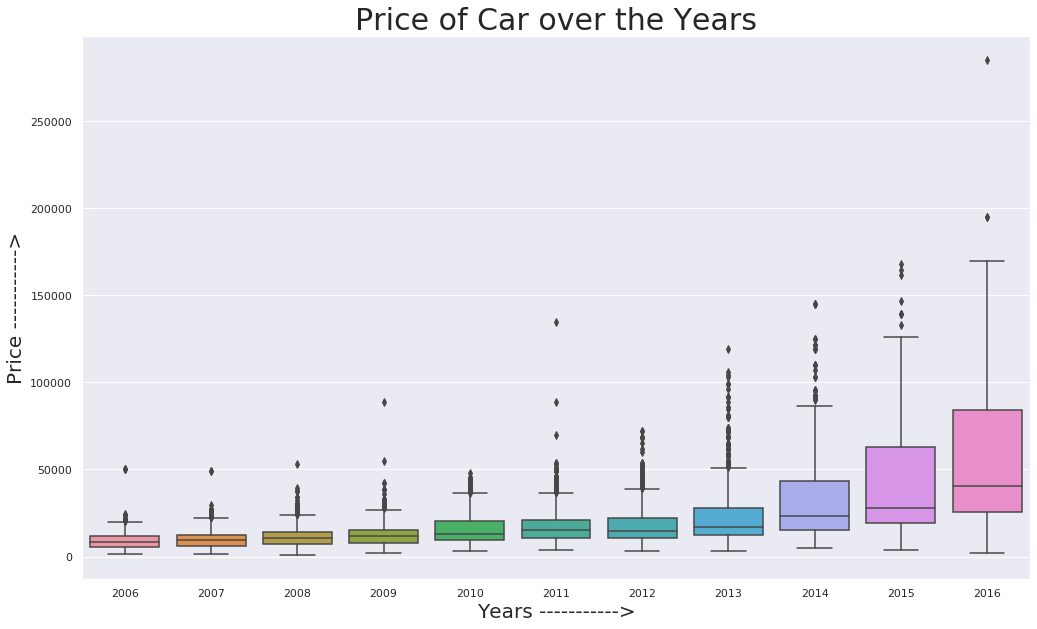

In [118]:
fig = plt.figure(figsize = (17,10))

ax1 = fig.add_subplot(1,1,1)
sns.boxplot(x = 'int_year', y = 'price', data = cars_df[cars_df['year'].dt.year > 2005][['int_year','price']], ax = ax1)

plt.title('Price of Car over the Years', fontsize = 30)
plt.xlabel('Years ----------->', fontsize = 20)
plt.ylabel('Price ----------->', fontsize = 20)
plt.show()

### Relationship : Mileage vs Price

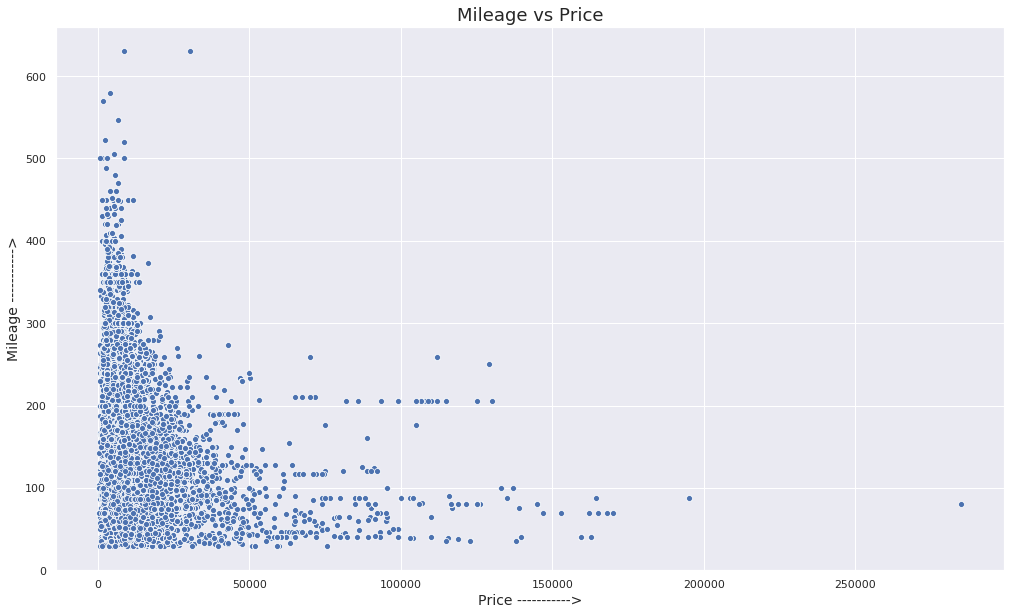

In [119]:
fig = plt.figure(figsize = (17,10))

ax = fig.add_subplot(1,1,1)
sns.scatterplot(x = 'price', y = 'mileage', data = cars_df, ax = ax)

plt.title('Mileage vs Price', fontsize = 18)
plt.xlabel('Price ----------->', fontsize = 14)
plt.ylabel('Mileage ----------->', fontsize = 14)

plt.show()

### Drive Type over the years

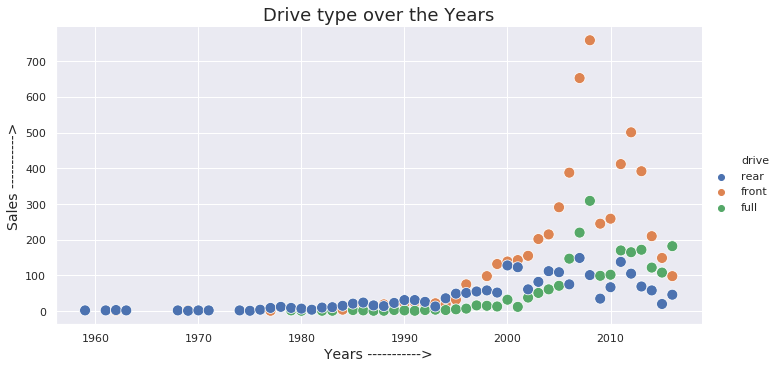

In [120]:
sns.relplot(x = 'year',y = 'sales', data = cars_df.groupby(['year','drive'])['sales'].sum().reset_index(),hue = 'drive', aspect = 2,s = 120)
plt.title('Drive type over the Years', fontsize = 18)
plt.xlabel('Years ----------->', fontsize = 14)
plt.ylabel('Sales ----------->', fontsize = 14)

plt.show()

### Car Body types over the years

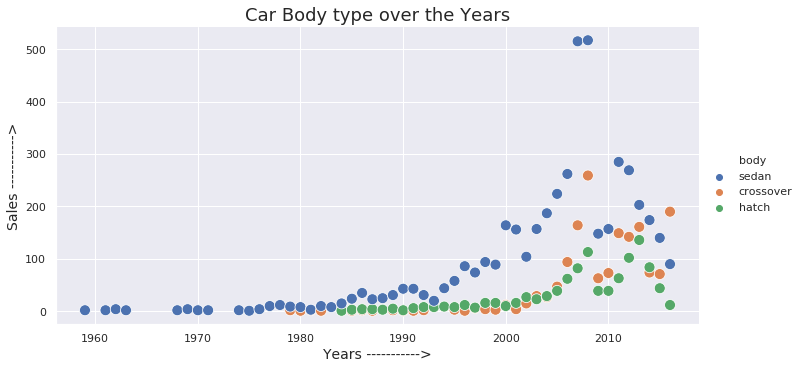

In [121]:
sns.relplot(x = 'year',y = 'sales', data = cars_df[cars_df['body'].isin(['sedan','hatch','crossover'])].groupby(['year','body'])['sales'].sum().reset_index(),hue = 'body', aspect = 2,s = 120)
plt.title('Car Body type over the Years', fontsize = 18)
plt.xlabel('Years ----------->', fontsize = 14)
plt.ylabel('Sales ----------->', fontsize = 14)

plt.show()

### Top5 Selling Cars

In [122]:
cars_df[cars_df['year'].dt.year > 2005].groupby('car')['sales'].sum().reset_index().sort_values(by = 'sales', ascending = False).reset_index(drop = True).head(5)

,car,sales
0,Mercedes-Benz,815
1,Toyota,695
2,Volkswagen,601
3,Renault,486
4,Nissan,431


In [123]:
top5 = cars_df[cars_df['car'].isin(['Mercedes-Benz','Toyota','Volkswagen','Renault','Nissan'])].groupby(['year','car'], as_index = False)['price','mileage','sales'].agg({'price' : 'mean','mileage':'mean','sales' : 'sum'}).sort_values(by = ['year','sales'])
top5.head()

,year,car,price,mileage,sales
0,1978-01-01,Mercedes-Benz,3900.00,350.5,6
1,1979-01-01,Toyota,600.00,117.5,2
3,1980-01-01,Volkswagen,1296.75,183.5,1
2,1980-01-01,Mercedes-Benz,7777.00,230.0,3
4,1983-01-01,Mercedes-Benz,2400.00,237.0,3


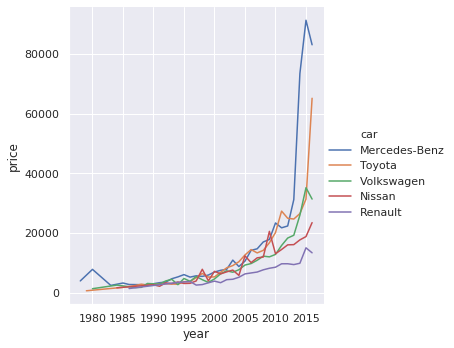

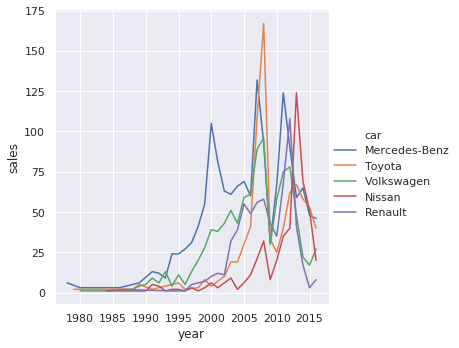

In [124]:
sns.relplot(x = 'year', y = 'price', hue = 'car', data = top5, kind = 'line')
sns.relplot(x = 'year', y = 'sales', hue = 'car', data = top5, kind = 'line')

### Other Relations

In [125]:
cars_df.cov()

,price,mileage,engV,sales
price,3.353911e+08,-454189.860009,5653.799816,0.0
mileage,-4.541899e+05,7247.880693,11.565858,0.0
engV,5.653800e+03,11.565858,0.620300,0.0
sales,0.000000e+00,0.000000,0.000000,0.0


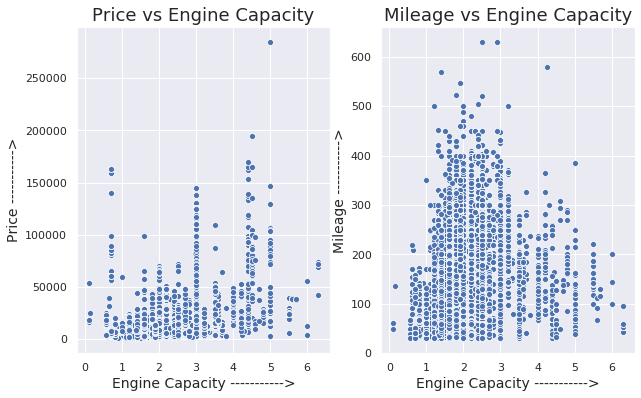

In [128]:
sns.set()
fig = plt.figure(figsize =(10,6))

ax1 = fig.add_subplot(1,2,1)
sns.scatterplot(x = 'engV', y = 'price', data = cars_df, ax = ax1)
plt.title('Price vs Engine Capacity', fontsize = 18)
plt.xlabel('Engine Capacity ----------->', fontsize = 14)
plt.ylabel('Price ----------->', fontsize = 14)


ax1 = fig.add_subplot(1,2,2)
sns.scatterplot(x = 'engV', y = 'mileage', data = cars_df, ax = ax1)
plt.title('Mileage vs Engine Capacity', fontsize = 18)
plt.xlabel('Engine Capacity ----------->', fontsize = 14)
plt.ylabel('Mileage ----------->', fontsize = 14)
plt.show()